# Depth Metrics

This repository/notebook aims to implement the affine invariant protocol for relative monocular depth estimation models

- Step 1: Load the data.

- Step 2: Pre-process: Transform into disparity, apply masks, deal with zero division.

- Step 3: Align the prediction with groundtruth with least squares algorithm

- Step 4: Calculate the Metrics (AbsRel, delta, RMSE)

- Step 5: Output the results in pandas dataframe and figures.  

### Coisas pra fazer:

1) **Zero Division**: Modificar cálculos para evitar divisão por zero  (check)

2) **Métricas**: implementar o código para outras métricas (delta123, RMSE) (check)
   1) Visualização: Pode cortar os valores extremantes da imagem para avaliação ou para visualização?
   2) ARRUMAR AS MASCARAS PARA AS IMAGENS EXTERNAS

3) **Loop de teste**: fazer rodar para todas as imagens do dataset   

4) **Saída**: salvar em dataframe  
   1) Dataframe com delta, absrel e...

5) **Realizar testes**: Teste no código de teste
   1) Imagens sintéticas com erros conhecidos para testar
   
6) Rodar nos outros datasets
   1) Codar individualmente o teste para cada um
   2) pensar numa maneira de isolar o carregamento dos dados
   
7) Exibir resultados de outras formas
   1) Codificar teste de erro por distância
   2) gerar imagens de erro
   3) pesquisar outras formas...

In [119]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
from utils import (get_sorted_files,  
                   abs_rel_error, 
                   cap_values, 
                   plot_histogram,  
                   depth_report, 
                   align_depth,
                   calculate_delta)


# Affine-Invariant Alignment

## 1. Load data

In [120]:
diode_path = Path("/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/")
diode_indoor = diode_path / "val" / "indoors"
diode_outdoor = diode_path / "val" / "outdoor"
diode_preds = Path("/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/")

filenames_img = get_sorted_files(diode_path, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_preds, ".npy")

In [121]:
index = 280
index = 600
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.squeeze(np.load(filenames_depth[index]))
rgb = np.array(Image.open(filenames_img[index]))
H,W = groundtruth.shape
mask = np.load(filenames_mask[index]).reshape((H, W))

## 2. Pre Processing

In [122]:
groundtruth_masked = np.zeros_like(groundtruth)
groundtruth_masked[mask == 1] = groundtruth[mask == 1]

disparity_gt_masked = np.zeros_like(groundtruth)
disparity_gt_masked[mask == 1] = 1.0 / groundtruth[mask == 1]

pred_depth = np.zeros_like(groundtruth) 
pred_depth[mask == 1] = 1.0 / pred_diode[mask == 1]

groundtruth_capped_upper = cap_values(groundtruth, 0, 99)
disparity_capped_upper = cap_values(disparity_gt_masked, 0, 99)

/tmp/ipykernel_24047/2636283355.py:8: RuntimeWarning: divide by zero encountered in divide
  pred_depth[mask == 1] = 1.0 / pred_diode[mask == 1]


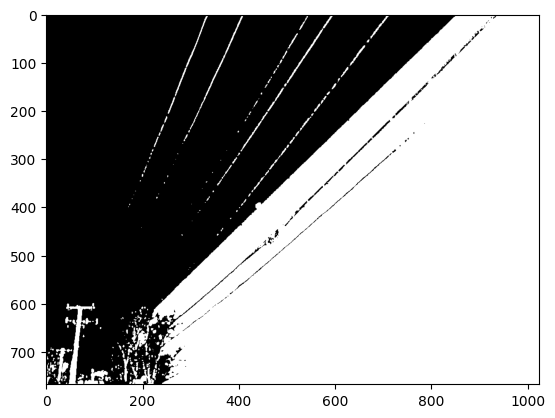

In [123]:
plt.imshow(mask, cmap="gray")

Visualization of the data 

- a) RGB Image
- b) Prediction from model in UINT8
- c) Groundtruth depth in UINT8
- d) Histogram from depth groundtruth

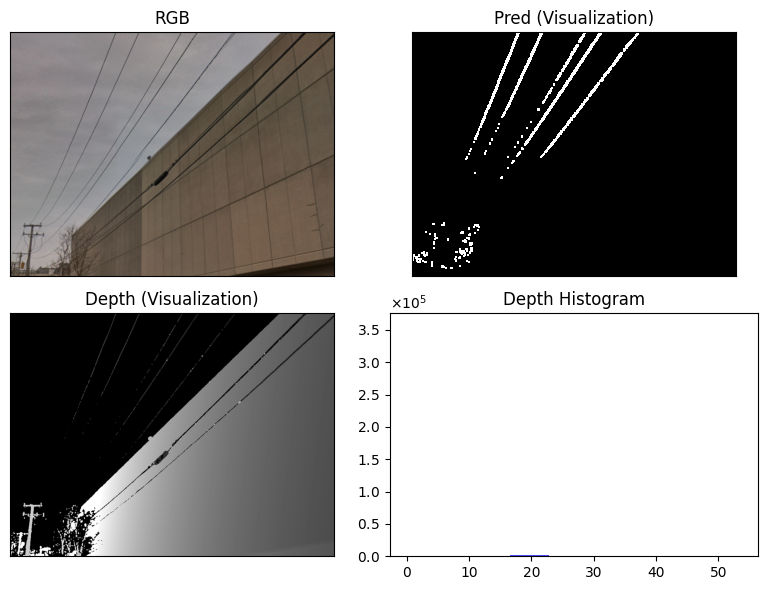

---- Depth Report ----

how many uniques: 409837
Max: 53.6702880859375
Min: 0.0
shape: (768, 1024)
Dtype: float32
---- Depth Report ----

how many uniques: 414550
Max: inf
Min: 0.0
shape: (768, 1024)
Dtype: float32


In [124]:
depth_report(rgb, groundtruth_capped_upper, pred_depth, cap=False, uint=False)

## 3. Alignment via least squares algorithm

In [125]:
depth_aligned_masked = align_depth(disparity_gt_masked, pred_diode, mask, return_depth=True, mask_output=True)

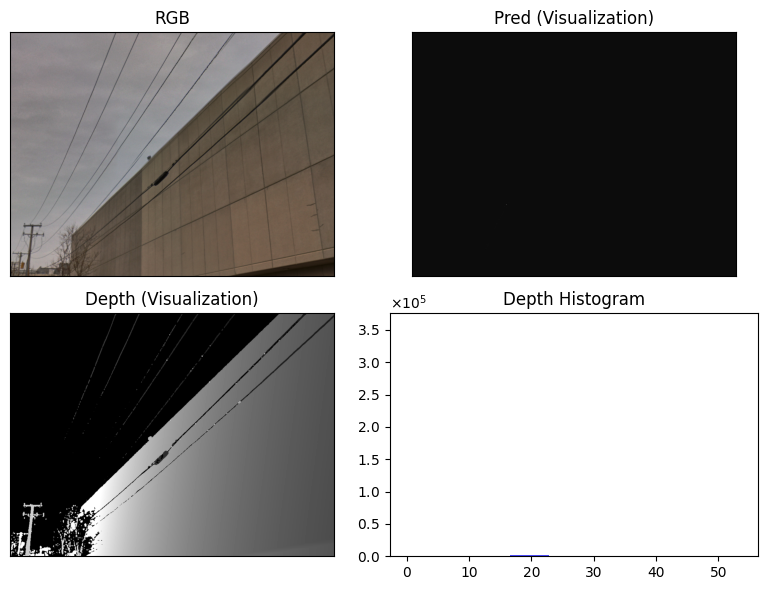

---- Depth Report ----

how many uniques: 409837
Max: 53.6702880859375
Min: 0.0
shape: (768, 1024)
Dtype: float32
---- Depth Report ----

how many uniques: 415443
Max: 9548352.295505155
Min: -505665.49997198663
shape: (768, 1024)
Dtype: float64


In [126]:
depth_report(rgb, groundtruth_capped_upper ,depth_aligned_masked, cap=False, uint=False)

Histogram of the groundtruth and depth aligned

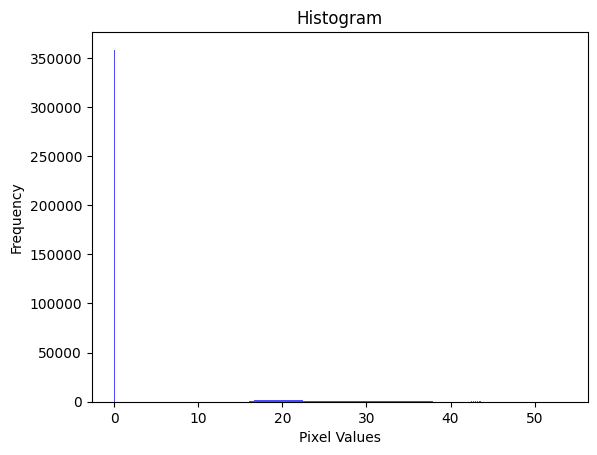

In [127]:
plot_histogram(groundtruth_capped_upper)

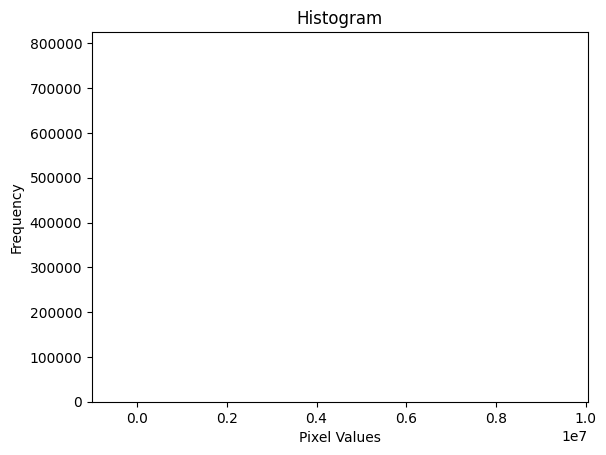

In [128]:
plot_histogram(depth_aligned_masked)

Visualization of a column of the groundtruth, and from the prediction. Then, align them both.

/tmp/ipykernel_24047/434709217.py:2: RuntimeWarning: divide by zero encountered in divide
  pred_depth = (1/pred_diode)*mask
/tmp/ipykernel_24047/434709217.py:2: RuntimeWarning: invalid value encountered in multiply
  pred_depth = (1/pred_diode)*mask


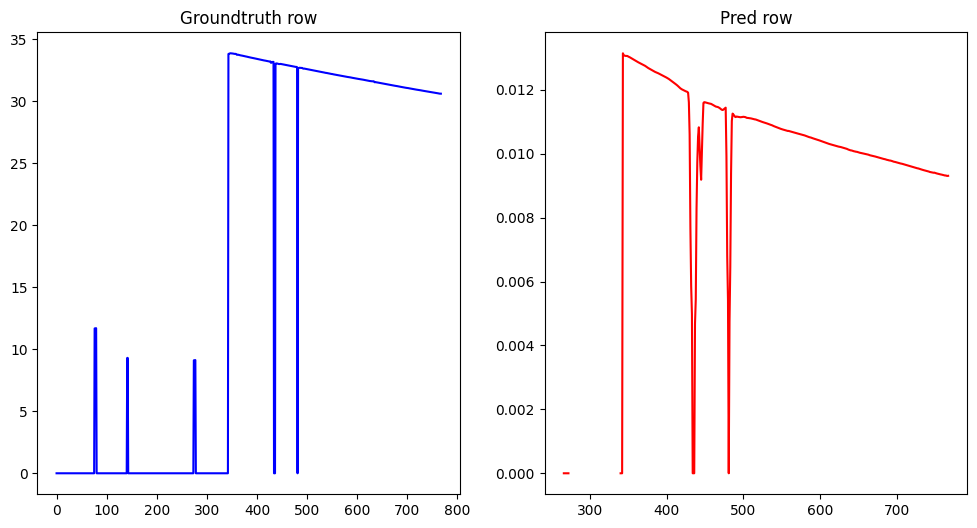

In [129]:
row_index = 500
pred_depth = (1/pred_diode)*mask
GT_row = groundtruth_capped_upper[:, row_index]
pred_row = pred_depth[:, row_index]
pred_aligned_row = depth_aligned_masked[:, row_index]


fig, ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot( GT_row, 'b')
ax[0].set_title("Groundtruth row")
ax[1].plot(pred_row, 'r')
ax[1].set_title("Pred row")
plt.show()

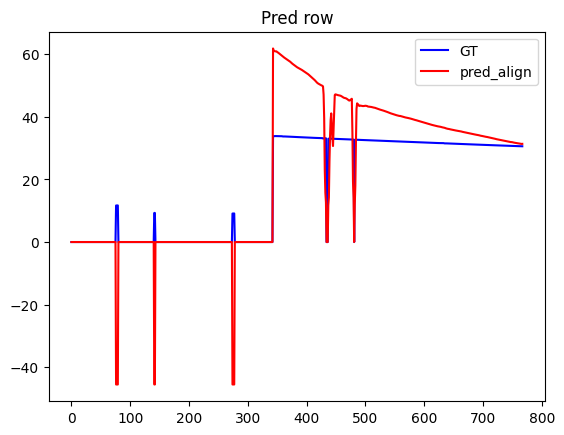

In [130]:
fig, ax = plt.subplots()
ax.plot(GT_row, 'b',label="GT")
ax.plot(pred_aligned_row, 'r', label="pred_align")
ax.set_title("Pred row")
ax.legend()
plt.show()

## 4. Calculate Metrics

### 4.1 metrics on groundtruth masked

In [131]:
abs_rel_error(depth_aligned_masked, groundtruth_masked)

np.float64(0.9420280529414949)

In [132]:
calculate_delta(depth_aligned_masked, groundtruth_masked, mask, threshold=1.25)

np.float64(72.22552164682335)

### 4.2 metrics on groundtruth capped

In [133]:
abs_rel_error(depth_aligned_masked, groundtruth_capped_upper)

np.float64(0.9624608366000778)

In [134]:
calculate_delta(depth_aligned_masked, groundtruth_capped_upper, mask, threshold=1.25)

np.float64(72.22669073428045)

## 5. Output the results